<a href="https://colab.research.google.com/github/KamauDennis/datascience_projects/blob/master/Training_an_Age_Detection_model_using_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training an Age Detector model using Deep Learning
Age detection is the process of automatically discerning the age of a person solely from a photo of their face.My goal here is to create a program that will predict the age of a person using an image.In this project I will treat age prediction as a classification problem rather than a regression problem where I will classify the age into a specific range.I'm going to train the age detection model from scratch using convolution neural networks in TensorFlow.
Let me begin by importing libraries that will be used:

In [ ]:
%matplotlib inline
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()

## Getting the data
In this project I'll be using the UTKFace dataset which consists of over 20,000 face images with annotations of age ranging from 0 to 116 years.I downloaded the dataset from [UTKFace dataset](https://susanqq.github.io/UTKFace/) to my google drive.

In [ ]:
#mounting google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#unzipping the dataset
from zipfile import ZipFile

with ZipFile('drive/MyDrive/Datasets/UTKFACE.zip','r') as f:
    f.extractall()    

In [ ]:
import os
filepaths = []
dir = 'UTKFace'
for root,subdirs,files in os.walk(dir):
    if dir in subdirs:
      subdirs.remove(dir)
    for file in files:
        filepath = os.path.join(root,file)
        filepaths.append(filepath)

In [ ]:
image_count = len(filepaths)

## Data preparation
In this project I will use TensorFlow's Data API to load and preprocess the images to be passed to the neural network.TensorFlow supports multithreading,queuing,caching and prefetching thus making it easy to read huge datasets efficiently.

First let me begin by creating a filepath dataset that contains a list of file paths of downloaded images.

In [ ]:
#lets first create a file dataset
filepath_dataset = tf.data.Dataset.list_files(filepaths,shuffle=True)
filepath_dataset = filepath_dataset.shuffle(image_count,reshuffle_each_iteration=False)
filepath_dataset.cardinality().numpy()

23708

Let me split the dataset to three subsets,ie training,validation and test set

In [ ]:
#splitting the dataset 
val_size = int(image_count*0.1)
training_ds = filepath_dataset.skip(val_size)
val_ds = filepath_dataset.take(val_size)
test_size = int(image_count*0.05)
train_ds = training_ds.skip(test_size)
test_ds = training_ds.take(test_size)
print("Train_ds size ",train_ds.cardinality().numpy())
print("Test_ds size ",test_ds.cardinality().numpy())
print("Val_ds size ",val_ds.cardinality().numpy())

Train_ds size  20153
Test_ds size  1185
Val_ds size  2370


In [ ]:
#lets take a look at what the dataset contains
for line in train_ds.take(5):
    print(line)

tf.Tensor(b'UTKFace/12_0_4_20170103201824880.jpg.chip.jpg', shape=(), dtype=string)
tf.Tensor(b'UTKFace/65_0_1_20170120224015174.jpg.chip.jpg', shape=(), dtype=string)
tf.Tensor(b'UTKFace/36_0_0_20170116002809469.jpg.chip.jpg', shape=(), dtype=string)
tf.Tensor(b'UTKFace/62_0_0_20170105173715821.jpg.chip.jpg', shape=(), dtype=string)
tf.Tensor(b'UTKFace/21_1_1_20170112193009590.jpg.chip.jpg', shape=(), dtype=string)


### Getting the labels
The tree structure of the files can be used to compile the list of class names and use it to create a function that converts a filepath to a (img,label) pair.

In [ ]:
def get_label(file_path):
    class_ = tf.strings.split(file_path,os.path.sep)[1]
    age_ = tf.strings.split(class_,'_')[0]
    age = tf.strings.to_number(age_,tf.int32)
    return age

age_lst = []
for line in train_ds:
    age = get_label(line)
    age_lst.append(age)

Lets plot a histogram to see the distribution of age across the dataset

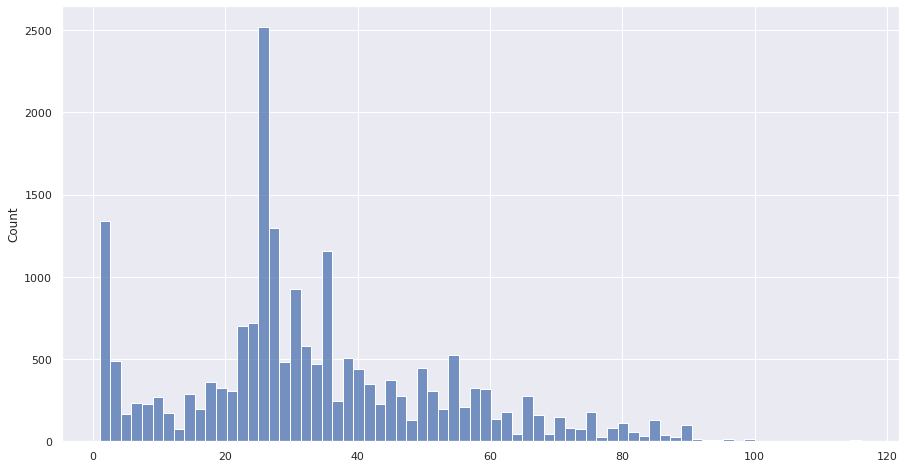

In [ ]:
data = np.array(age_lst)
x = range(0,121)
plt.figure(figsize=(15,8))
sns.histplot(data)
#plt.hist(age_lst,bins=30)

There is quite a class imbalance with age ranging from 20 to 40 represented  more than the others. 

I will split the data into eight age groups as follows

    - Infant(0-1 year) -encoded to 0
    - Toddler(2-5 years) -encoded to 1
    - Child(6-12 years) -encoded to 2
    - Teen (13-19 years) -encoded to 3
    - Youth(20-29 years) -encoded to 4
    - Middle Age Adult(30-39 years) -encoded to 5
    - Senior Adult(40-59 years) -encoded to 6
    - Aging (60-120 years) -encoded to 7

In [ ]:
class_names = ['0-1','2-5','6-12','13-19','20-29','30-39','40-59','60-120']
tf_class_names = tf.constant(['0-1','2-5','6-12','13-19','20-29','30-39','40-59','60-120'])

def get_labels(y):
  labels_lst = []
  class_names = ['0-1','2-5','6-12','13-19','20-29','30-39','40-59','60-120']
  for x in class_names:
    lower_lim = int(x.split('-')[0])
    upper_lim = int(x.split('-')[1])
    if (y>=lower_lim) and (y<=upper_lim):
      labels_lst.append(x)
  label = labels_lst[0]  
  return label 

#encoding labels
indices = tf.range(len(class_names),dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(class_names,indices)
table = tf.lookup.StaticHashTable(table_init,default_value=-1)


label_lst = []
for age in age_lst:
    label = get_labels(age)
    label = tf.constant(label)
    label_indices = table.lookup(label)
    label_one_hot = tf.one_hot(label_indices,depth=len(class_names),dtype=tf.int64)
    label_lst.append(label_indices.numpy()) 

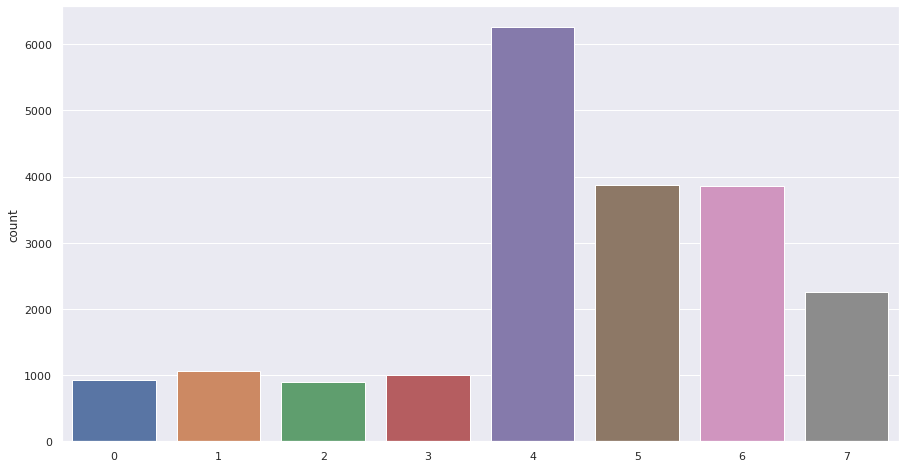

In [ ]:
labels = label_lst
plt.figure(figsize=(15,8))
sns.countplot(x=label_lst)

Class imbalance still exist even after grouping the dataset into eight groups.Imbalance classification pose a challenge for predictive modeling as most machine learning algorithms are designed around the assumption of an equal number of examples for each class.There are a number of ways of alleviating this problem but I will focus on weight balancing.Weight balancing balances our data by altering the weight that each training example carries when computing the loss.The keras model fit method provides a parameter for setting class weights all you need is pass a dictionary containing class weights.I will use sklearn to calculate class weights for each class.

In [ ]:
from sklearn.utils import class_weight
class_weights = dict(zip(np.unique(label_lst), class_weight.compute_class_weight('balanced',classes=np.unique(label_lst), 
                y=label_lst))) 
class_weights

{0: 2.702923819742489,
 1: 2.378777148253069,
 2: 2.799027777777778,
 3: 2.511590229312064,
 4: 0.40260907783282723,
 5: 0.649426398556329,
 6: 0.6526230569948187,
 7: 1.113179407865665}

In [ ]:
def find_labels(y):
    lst =tf.constant(['0-1','2-5','6-12','13-19','20-29','30-39','40-59','60-120']) 
    label_lst =tf.TensorArray(tf.string, size=1, dynamic_size=False, clear_after_read=True)
    for x in lst:
        lower_lim = tf.strings.to_number(tf.strings.split(x,sep='-')[0],tf.int32)
        upper_lim = tf.strings.to_number(tf.strings.split(x,sep='-')[1],tf.int32)
        if (y>=lower_lim) and (y<=upper_lim):
            label_lst = label_lst.write(0,x)
    label = label_lst.read(0)
    #print(label)
    return label 

In [ ]:
#a function that encodes the labels to onehot
def encode_labels(label):
    indices = tf.range(len(class_names),dtype=tf.int32)
    table_init = tf.lookup.KeyValueTensorInitializer(class_names,indices)
    table = tf.lookup.StaticHashTable(table_init,default_value=-1)
    label_indices = table.lookup(label)
    label_one_hot = tf.one_hot(label_indices,depth=len(class_names),dtype=tf.int64)
    return label_one_hot

def get_label(file_path):
    class_ = tf.strings.split(file_path,os.path.sep)[1]
    age_ = tf.strings.split(class_,'_')[0]
    gender_ = tf.strings.split(class_,'_')[1]
    race_ = tf.strings.split(class_,'_')[2]
    gender = tf.strings.to_number(gender_,tf.int32)
    age = tf.strings.to_number(age_,tf.int32)
    label_age = find_labels(age)
    label_indices = table.lookup(label_age)
    label_one_hot = tf.one_hot(label_indices,depth=len(class_names),dtype=tf.int64)
    #one_hot = encode_labels(label_age)
    return tf.argmax(label_one_hot)

In [ ]:
#define some parameters 
batch_size = 32
img_height = 200
img_width = 200

In [ ]:
def decode_img(img):
    #convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img,channels=3)
    return tf.image.resize(img,[img_height,img_width])

def process_path(file_path):
    label = get_label(file_path)
    #load the raw data from the path as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img,label

In [ ]:
#use Dataset.map to create a dataset of image,label pair
#set number of parallel calls so multiple images are loaded/processed in parallel
train_ds = train_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path,num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for image,label in train_ds.take(5):
    print("Image Shape: ",image.numpy().shape)
    print("Label: ",label.numpy())
     #print ("Gender: ",label[1].numpy())

Image Shape:  (200, 200, 3)
Label:  7
Image Shape:  (200, 200, 3)
Label:  6
Image Shape:  (200, 200, 3)
Label:  6
Image Shape:  (200, 200, 3)
Label:  6
Image Shape:  (200, 200, 3)
Label:  6


## Configure Dataset for performance
To train a model with this dataset we'll want the data:

      - To be shuffled
      - To be batched
      - Batches to be available as soon as possible
These features can be added using the tf.data Api      

In [ ]:
def configure_for_performance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(1)
    return(ds)

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

## Visualize the data
Let's plot a few of these faces to see what we are working with

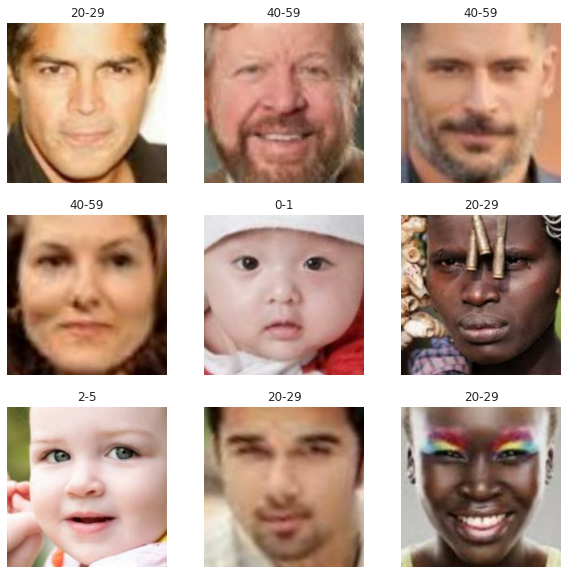

In [ ]:
image_batch,label_batch = next(iter(train_ds))

plt.figure(figsize=(10,10))

for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].numpy().astype('uint8'))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis('off')

## Training Convolutional Neural Networks(CNNs)
Convolutional neural network is a class of artificial neural network,most commonly used to analyze visual imagery.I will train a convolution neural network from scratch using ResNet architecture.

In [ ]:
#Let's first create a ResidualUnit layer
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation='relu',**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters,3,strides=strides,padding='same',use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters,3,strides=1,padding='same',use_bias=False),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters,1,strides=strides,padding='same',use_bias=False),
                keras.layers.BatchNormalization()
            ]
        
    def call(self,inputs):
        Z =inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)    

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64,7,strides=2,input_shape=[200,200,3],padding='same',use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters,strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8,activation='softmax'))

In [ ]:
#compiling the model
model.compile(loss=["sparse_categorical_crossentropy"],
             optimizer=keras.optimizers.Adam(learning_rate=0.01,beta_1=0.9,beta_2=0.999),
             metrics='accuracy')

In [ ]:
#training the model
history = model.fit(train_ds,epochs=40,validation_data=val_ds,class_weight=class_weights)

Epoch 1/40
630/630 [==============================] - 129s 180ms/step - loss: 2.1196 - accuracy: 0.2242 - val_loss: 1.9914 - val_accuracy: 0.3338
Epoch 2/40
630/630 [==============================] - 113s 177ms/step - loss: 1.6161 - accuracy: 0.3008 - val_loss: 1.5706 - val_accuracy: 0.3776
Epoch 3/40
630/630 [==============================] - 113s 177ms/step - loss: 1.4516 - accuracy: 0.3505 - val_loss: 1.6336 - val_accuracy: 0.2684
Epoch 4/40
630/630 [==============================] - 112s 174ms/step - loss: 1.3138 - accuracy: 0.4056 - val_loss: 3.2124 - val_accuracy: 0.1717
Epoch 5/40
630/630 [==============================] - 109s 171ms/step - loss: 1.1953 - accuracy: 0.4542 - val_loss: 2.1049 - val_accuracy: 0.2190
Epoch 6/40
630/630 [==============================] - 109s 171ms/step - loss: 1.1083 - accuracy: 0.4876 - val_loss: 4.9014 - val_accuracy: 0.1532
Epoch 7/40
630/630 [==============================] - 108s 170ms/step - loss: 1.0350 - accuracy: 0.5110 - val_loss: 1.1788 -

In [ ]:
eval = model.evaluate(test_ds)

38/38 [==============================] - 5s 56ms/step - loss: 0.6571 - accuracy: 0.8076


In [ ]:
model_version = "0001"
model_name = "age_detector_model"
model_root = 'drive/MyDrive'
model_path = os.path.join(model_name,model_version)
model_path = os.path.join(model_root,model_path)
tf.saved_model.save(model,model_path)

## Conclusion and further work
The task for recognizing age is a troublesome issue,more so than numerous other computer vision tasks.To improve model accuracy the CNN can be trained with a larger dataset with more variations in the images.